# proj1 — Colorizing the Prokudin-Gorskii Photo Collection

The goal of this assignment is to take the digitized Prokudin-Gorskii glass plate images and, using image processing techniques, automatically produce a color image with as few visual artifacts as possible. To do this, we extract the three color channel images, place them on top of each other, and align them so that they form a single RGB color image.

Note that the filter order for these images is BGR from top to bottom!

### Single-Scale Implementation: Trying Out All Possible Displacements
The easiest way to align the parts is to 
1. Exhaustively search over a window of possible displacements (say [-15,15] pixels), 
2. Score each one using some image matching metric, 
3. Take the displacement with the best score. 

We use the L2 norm and the Normalized Cross Correlation as alignment metrics for the single-scale implementation.

In [ ]:
import numpy as np
import skimage as sk
import skimage.io as skio


# IO
def get_channels(input_img):
    im = skio.imread(input_img)

    im = sk.img_as_float(im)
        
    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    return b, g, r


# METRICS
def euclidean_metric(im1, im2, mask):
    # return np.sqrt(np.sum((im1 - im2)**2))
    diff = (im1 - im2)[mask].astype(np.float32)
    err = np.sqrt(np.sum(diff**2))
    return err

def ncc_metric(im1, im2, mask):
    im1, im2 = im1[mask].astype(np.float32), im2[mask].astype(np.float32)
    im1_mag, im2_mag = np.linalg.norm(im1), np.linalg.norm(im2)
    err = 0.0 if (im1_mag == 0 or im2_mag == 0) else float(np.dot(im1/im1_mag, im2/im2_mag))
    return err

def zncc_metric(im1, im2, mask):
    im1, im2 = im1[mask].astype(np.float32), im2[mask].astype(np.float32)
    im1, im2 = im1 - im1.mean(), im2 - im2.mean()
    im1_mag, im2_mag = np.linalg.norm(im1), np.linalg.norm(im2)
    err = 0.0 if (im1_mag == 0 or im2_mag == 0) else float(np.dot(im1/im1_mag, im2/im2_mag))
    return err

# ALIGNMENT
def align_and_stack(im1, im2, im3, metric='euclidean', alignment_ch='blue', disp_window=[-15,15]):
    # Swap top image (blue) to change alignment channel to green/red
    if alignment_ch == 'green':
        im1_temp = im1
        im1 = im2
        im2 = im1_temp

    elif alignment_ch == 'red':
        im1_temp = im1
        im1 = im3
        im3 = im1_temp

    # Align second and third images to top image
    im2, shift_im2 = align(im1, im2, metric, disp_window)
    im3, shift_im3 = align(im1, im3, metric, disp_window)

    if alignment_ch == 'green':
        im2_temp = im2
        im2 = im1
        im1 = im2_temp

    if alignment_ch == 'red':
        im3_temp = im3
        im3 = im1
        im1 = im3_temp
        
    return np.dstack([im3, im2, im1]), [shift_im2, shift_im3]
    

def align(im1, im2, metric, disp_window):
    best = np.inf if metric == 'euclidean' else -np.inf
    shift = [0, 0]
    mask = np.ones(im1.shape, dtype=bool)

    for dx in range(disp_window[0], disp_window[-1] + 1):
        for dy in range(disp_window[0], disp_window[-1] + 1):
            im2_r = np.roll(im2, (dx, dy), axis=(0,1))

            if metric == 'euclidean':
                err = euclidean_metric(im1, im2_r, mask)
                if err < best:
                    shift = [dx, dy]
                    best = err

            elif metric == 'ncc':
                err = ncc_metric(im1, im2_r, mask)
                if err > best:
                    shift = [dx, dy]
                    best = err
                
            elif metric == 'zncc':
                err = zncc_metric(im1, im2_r, mask)
                if err > best:
                    shift = [dx, dy]
                    best = err

    res = np.roll(im2, shift=(shift[0], shift[1]), axis=(1, 0))
    return res, shift

In [190]:
# TEST
imfolder = './media/'
imname = 'cathedral.jpg'
b, g, r = get_channels(imfolder + imname)

colorized_b, shifts_b = align_and_stack(b, g, r, alignment_ch='blue', metric='euclidean')
colorized_g, shifts_g = align_and_stack(b, g, r, alignment_ch='green', metric='euclidean')
colorized_r, shifts_r = align_and_stack(b, g, r, alignment_ch='red', metric='euclidean')

print("blue shifts", shifts_b)
print("green shifts", shifts_g)
print("red shifts", shifts_r)

blue shifts [[1, -1], [7, -1]]
green shifts [[-1, 1], [7, 0]]
red shifts [[-7, 0], [-7, 1]]


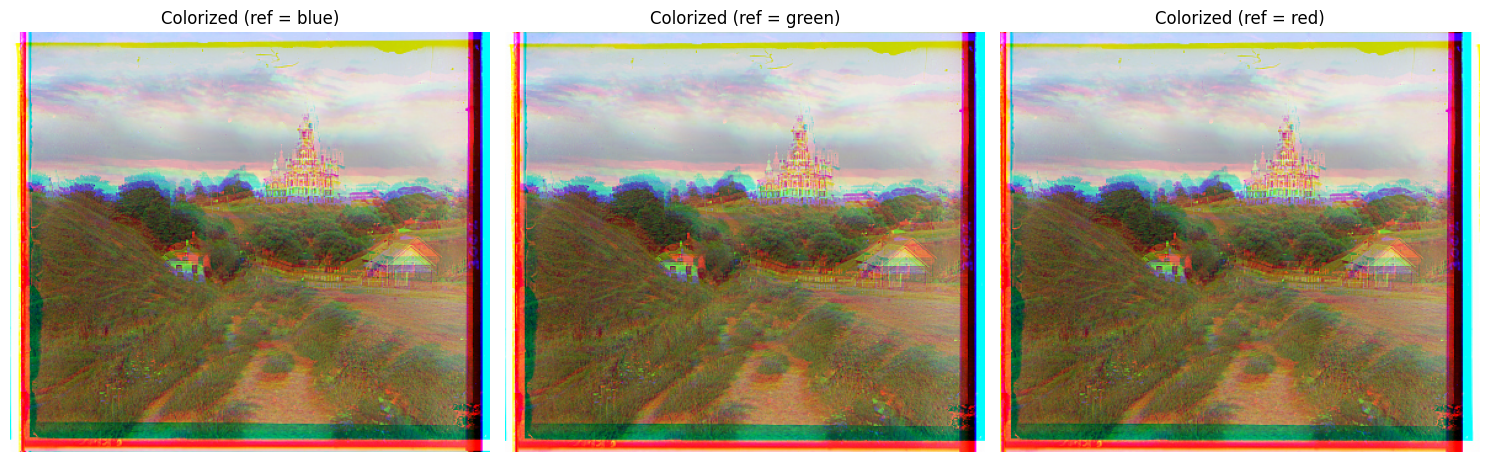

In [ ]:
# PLOT 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
imgs = [colorized_b, colorized_g, colorized_r]
titles = ["Colorized (ref = blue)", "Colorized (ref = green)", "Colorized (ref = red)"]

for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

Significant alignment artifacts are present, which is expected, since we are ignoring the black borders that were not properly removed when the initial image was cropped in 3. There are also issues since np.roll wraps the image around. We can attempt to mitigate the above problems by only taking "valid" portions of the image into account when computing the best alignment.

In [192]:
A = np.arange(1, 10).reshape(3,3)
Ar = np.roll(A, (-1, 0), axis=(1, 0))
print(A)
print(Ar)

mask = np.ones((3,3), dtype=bool)


mask[:, -1:] = False
print(mask)

# print(mask[:1,:])
# print(mask[1:,:])

# print(mask)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[2 3 1]
 [5 6 4]
 [8 9 7]]
[[ True  True False]
 [ True  True False]
 [ True  True False]]


In [193]:
def wrap_mask(shape, dx, dy):
    # depending on which way the image is shifted, that part of the image will wrap around and we should not take those pixels into account
    # when calculating the error
    H, W = shape[:2]
    mask = np.ones((H, W), dtype=bool)

    if dy > 0: # shifted down, bottom ends up at top and needs to be cropped out
        mask[:dy, :] = False
    if dy < 0: # shifted up, top ends up at bottom and needs to be cropped out
        mask[dy:, :] = False

    if dx > 0: # shifted right, crop out leftmost part
        mask[:, :dx] = False
    if dx < 0: # shifted left, crop out rightmost part
        mask[:, dx:] = False
    return mask


def crop_mask(shape, frac=0.2):
    H, W = shape[:2]
    if frac <= 0:
        return np.ones((H, W), dtype=bool) # naive

    vcrop = int(frac * H)
    hcrop = int(frac * W)

    if vcrop == 0 and hcrop == 0:
        return np.ones((H, W), dtype=bool)

    # Crop has to be valid dim
    if (H - 2*vcrop) <= 0 or (W - 2*hcrop) <= 0:
        return np.ones((H, W), dtype=bool)

    mask = np.zeros((H, W), dtype=bool)
    mask[vcrop:(H - vcrop), hcrop:(W - hcrop)] = True
    return mask


In [194]:
def align_masked(im1, im2, metric, disp_window):
    best = np.inf if metric == 'euclidean' else -np.inf
    shift = [0, 0]

    # precompute crop mask once and tune frac
    mask_cr = crop_mask(im1.shape, frac=0.30)

    lo, hi = disp_window[0], disp_window[-1]
    for dx in range(lo, hi + 1):
        for dy in range(lo, hi + 1):
            im2_r = np.roll(im2, shift=(dy, dx), axis=(0, 1))

            # per-shift no-wrap mask
            mask_wr = wrap_mask(im1.shape, dx, dy)
            mask = mask_wr & mask_cr
            if not mask.any():
                continue

            if metric == 'euclidean':
                diff = (im1 - im2_r)[mask].astype(np.float32)
                err = float(np.sum(diff * diff))
                better = err < best
            elif metric == 'ncc':
                err = ncc_metric(im1, im2_r, mask)
                better = err > best
            else:
                err = zncc_metric(im1, im2_r, mask)
                better = err > best

            if better:
                best = err
                shift = [dy, dx]

    res = np.roll(im2, shift=(shift[0], shift[1]), axis=(0, 1))
    return res, shift


def align_and_stack_masked(im1, im2, im3, metric='euclidean', alignment_ch='blue', disp_window=[-15,15]):
    # Swap top image (blue) to change alignment channel to green/red
    if alignment_ch == 'green':
        im1_temp = im1
        im1 = im2
        im2 = im1_temp

    elif alignment_ch == 'red':
        im1_temp = im1
        im1 = im3
        im3 = im1_temp

    # Align second and third images to top image
    im2, shift_im2 = align_masked(im1, im2, metric, disp_window)
    im3, shift_im3 = align_masked(im1, im3, metric, disp_window)

    if alignment_ch == 'green':
        im2_temp = im2
        im2 = im1
        im1 = im2_temp

    if alignment_ch == 'red':
        im3_temp = im3
        im3 = im1
        im1 = im3_temp
        
    return np.dstack([im3, im2, im1]), [shift_im2, shift_im3]

In [195]:
# TEST
imfolder = './media/'
imname = 'cathedral.jpg'
b, g, r = get_channels(imfolder + imname)

colorized_b, shifts_b = align_and_stack_masked(b, g, r, alignment_ch='blue', metric='euclidean')
colorized_g, shifts_g = align_and_stack_masked(b, g, r, alignment_ch='green', metric='euclidean')
colorized_r, shifts_r = align_and_stack_masked(b, g, r, alignment_ch='red', metric='euclidean')

print("blue shifts", shifts_b)
print("green shifts", shifts_g)
print("red shifts", shifts_r)

blue shifts [[5, 2], [12, 3]]
green shifts [[-5, -2], [7, 1]]
red shifts [[-7, -1], [-12, -3]]


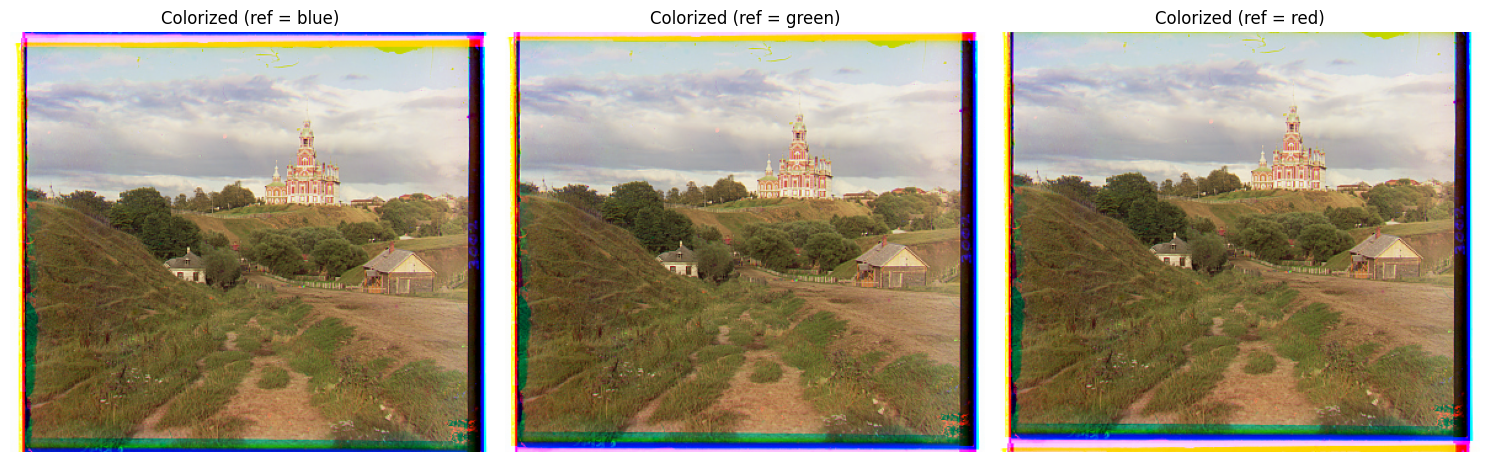

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
imgs = [colorized_b, colorized_g, colorized_r]
titles = ["Colorized (ref = blue)", "Colorized (ref = green)", "Colorized (ref = red)"]

for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Multi-Scale Pyramid Implementation: Rescaling for Speed
An image pyramid represents the image at multiple scales (usually scaled by a factor of 2) and the processing is done sequentially starting from the coarsest scale (smallest image) and going down the pyramid, updating your estimate as you go. It is very easy to implement by adding recursive calls to the original single-scale implementation. 

In [ ]:
def downsample(im, n):
    # maybe add gaussian
    return im[::n, ::n]

def build_pyramid(im, levels=3, scale=2):
    pyr = [im]
    cur = im
    for _ in range(1, levels):
        cur = downsample(cur, scale)
        pyr.append(cur)
    return pyr[::-1] # coarse->fine order

In [ ]:
def align_masked_pyr(im1_pyr, im2_pyr, metric, pyr_factor, coarse_radius=15, refine_radius=3):
    # imNUM_pyr are lists in coarse->fine order
    # returns the finest-level aligned image and the final (dy, dx) shift in finest pixels.

    guess_dy, guess_dx = 0, 0
    im2_curr = im2_pyr[0] #random

    for s, (im1_s, im2_s) in enumerate(zip(im1_pyr, im2_pyr)):
        # BASE CASE
        if s == 0:
            im2_aligned, delta = align_masked(im1_s, im2_s, metric, disp_window=[-coarse_radius, coarse_radius])
            guess_dy, guess_dx = delta[0], delta[1]
            im2_curr = im2_aligned

        else:

            guess_dy, guess_dx = guess_dy * pyr_factor, guess_dx * pyr_factor
            im2_guess = np.roll(im2_s, shift=(guess_dy, guess_dx), axis=(0, 1))

            # Refine with a small fixed radius around 0
            r = max(3, refine_radius)  # keep small; fixed-size is fast and robust
            im2_refined, delta = align_masked(im1_s, im2_guess, metric, disp_window=[-r, r])

            # Accumulate total shift at this finer level
            guess_dy += delta[0]
            guess_dx += delta[1]
            im2_curr = im2_refined

    return im2_curr, [int(guess_dy), int(guess_dx)]



def align_and_stack_masked_pyr(im1, im2, im3, metric='euclidean', alignment_ch='blue', pyr_factor=2):
    # Swap top image (blue) to change alignment channel to green/red
    if alignment_ch == 'green':
        im1_temp = im1
        im1 = im2
        im2 = im1_temp

    elif alignment_ch == 'red':
        im1_temp = im1
        im1 = im3
        im3 = im1_temp

    # Compute pyramid arrays for each image 
    im1_pyr, im2_pyr, im3_pyr = build_pyramid(im1), build_pyramid(im2), build_pyramid(im3)

    # Align with pyramid search
    im2, shift_im2 = align_masked_pyr(im1_pyr, im2_pyr, metric, pyr_factor)
    im3, shift_im3 = align_masked_pyr(im1_pyr, im3_pyr, metric, pyr_factor)

    if alignment_ch == 'green':
        im2_temp = im2
        im2 = im1
        im1 = im2_temp

    if alignment_ch == 'red':
        im3_temp = im3
        im3 = im1
        im1 = im3_temp
        
    return np.dstack([im3, im2, im1]), [shift_im2, shift_im3]

In [ ]:
# TEST
imfolder = './media/'
imname = 'emir.tif'
b, g, r = get_channels(imfolder + imname)

colorized_b, shifts_b = align_and_stack_masked_pyr(b, g, r, alignment_ch='blue', metric='euclidean')
colorized_g, shifts_g = align_and_stack_masked_pyr(b, g, r, alignment_ch='green', metric='euclidean')
colorized_r, shifts_r = align_and_stack_masked_pyr(b, g, r, alignment_ch='red', metric='euclidean')

print("blue shifts", shifts_b)
print("green shifts", shifts_g)
print("red shifts", shifts_r)

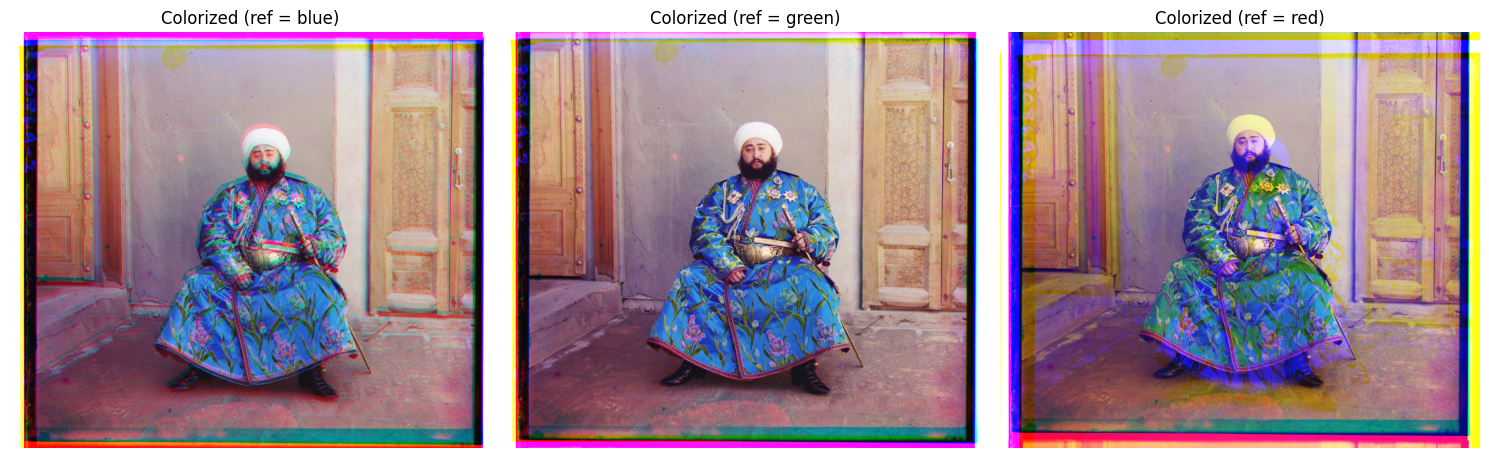

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
imgs = [colorized_b, colorized_g, colorized_r]
titles = ["Colorized (ref = blue)", "Colorized (ref = green)", "Colorized (ref = red)"]

for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()